# Pytorch's ANN and CNN, and a from scratch implementation using the MNIST dataset
## Andriotis Nikolaos

The assignment is divided into 2 parts. The first part is me trying to learn Pytorch's framework to create 2 implementations to solve the MNIST dataset. The first implementation is an ANN and the second one is a CNN. The second part is me trying to delve deeper into the algorithms and create a network using only numpy.

## Pytorch's ANN Part

In [632]:
import torch # since we are going to be using the framework
import torch.nn as nn # to access the nn.Module class
import torch.nn.functional as F # for relu
from torch.utils.data import DataLoader # lets us load data in batches
from torchvision import datasets, transforms # to split and change the data downloaded
import matplotlib.pyplot as plt
import time

### Load the MNIST dataset
This is done through torchvision. Torchvision will download a copy locally to your computer. Before actually downloading the dataset we have to make sure that the information is converted to tensors since Pytorch uses tensors. This is done using the last import!

In [633]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)
# The only difference between those statements are the argument "train"

Let's see what we got.

In [634]:
train_data, type(train_data)

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./Data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 torchvision.datasets.mnist.MNIST)

In [635]:
test_data, type(test_data)

(Dataset MNIST
     Number of datapoints: 10000
     Root location: ./Data
     Split: Test
     StandardTransform
 Transform: ToTensor(),
 torchvision.datasets.mnist.MNIST)

Calling the first record from train_data returns a tuple containing the pixel information (28x28 tensor) and the label (int). Same goes for the test_data.

In [636]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


And the actual image

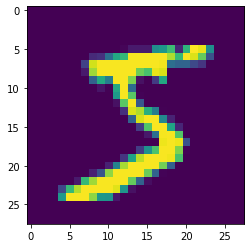

In [637]:
plt.imshow(image.reshape(28,28))

### Load it into batches

For this, I am going to be using DataLoader (4th import). My training set contains 60,000 records. If for every record I update all the thousands of parameters (I will actually see how many there are), it is going to take a lot of time. Thus, I split it into batches of 100 for the training set and batches of 500 for the test test.

In [638]:
torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

I have to flatten them. I will use .view()

In [639]:
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([100, 1, 28, 28])


### Model Definition

Since I will be varying the neurons, it makes sence to define the model more generally.

In [640]:
class ANN(nn.Module):
    
    def __init__(self, hidden_sizes):
        
        super().__init__()
        
        n_in = 784
        n_out = 10
        
        layerlist = []
        for i in hidden_sizes:
            
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            n_in = i
            
        layerlist.append(nn.Linear(hidden_sizes[-1], n_out))
        
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x):
        x = self.layers(x)
        return x

In [641]:
torch.manual_seed(42)
ann = ANN([120,84]) # e.g
ann

ANN(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

We can see that with a hidden layer consisting of 120 neurons and 84 neurons, the number of parameters is very large. This is one of the motivations for moving to CNN.

In [642]:
sum = 0
for param in ann.parameters():
    sum += param.numel()
sum

105214

### Define Process, Loss function & optimizer
I will use CrossEntropyLoss() to see differences since I will be using MSE for the other implementations. Adam is a no-brainer.

In [643]:
accuracy1 = []

def experiment_ann(ann, epochs, lr):
    
    import time
    start_time = time.time()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(ann.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []


    for i in range(epochs):
        trn_corr = 0 # measures how many were correct per epoch from the training examples
        
    
        # For each train batch
        # X_train has 100 images
        # y_train has 100 labels
        for b, (X_train, y_train) in enumerate(train_loader):
            b += 1
        
            # Apply the model
            y_pred = ann(X_train.view(100,-1))
            loss = criterion(y_pred, y_train)
        
            # How many did we got correct?
            # y_pred is 100x10 so for each image it has 10 percentages
            # torch.max returns the maximum values and indices for each row
            predicted = torch.max(y_pred, 1)[1]
        
            trn_corr += (predicted == y_train).sum() # total correct for the epoch
        
            optimizer.zero_grad() # set the gradients to zero before starting backprop
            loss.backward() # apply backprop
            optimizer.step() # update weights and biases by taking a step
    
            if b%200 == 0:
                print(f'epoch: {i:2} | train_batch: {b:4} [{100*b:6}/60000] | train_loss: {loss.item():10.8f} | train_accuracy: {trn_corr.item()*100/(100*b):7.3f}%')

        
        train_losses.append(loss) # loss per epoch
        train_correct.append(trn_corr) # num of correct per epoch
        
        tst_corr = 0 # measures how many were correct per epoch from the test examples
        
        # Lets test our progress
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):
                b += 1
                y_val = ann(X_test.view(500, -1))

                predicted = torch.max(y_val.data, 1)[1]
                tst_corr += (predicted == y_test).sum()
                
                if b%5 == 0:
                    accuracy1.append(tst_corr.item()*100/(500*b))
                    print(f'epoch: {i:2} | test_batch: {b:4} [{500*b:6}/10000] | test_loss: {loss.item():10.8f} | test_accuracy: {accuracy1[-1]:7.3f}%')
            
            loss = criterion(y_val, y_test)
            test_losses.append(loss)
            test_correct.append(tst_corr)

    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

In [644]:
torch.manual_seed(42)
ann = ANN([120,84])
experiment_ann(ann, 5, 0.001)

epoch:  0 | train_batch:  200 [ 20000/60000] | train_loss: 0.35620013 | train_accuracy:  82.365%
epoch:  0 | train_batch:  400 [ 40000/60000] | train_loss: 0.30093771 | train_accuracy:  87.037%
epoch:  0 | train_batch:  600 [ 60000/60000] | train_loss: 0.12693369 | train_accuracy:  89.237%
epoch:  0 | test_batch:    5 [  2500/10000] | test_loss: 0.12693369 | test_accuracy:  93.280%
epoch:  0 | test_batch:   10 [  5000/10000] | test_loss: 0.12693369 | test_accuracy:  93.420%
epoch:  0 | test_batch:   15 [  7500/10000] | test_loss: 0.12693369 | test_accuracy:  94.533%
epoch:  0 | test_batch:   20 [ 10000/10000] | test_loss: 0.12693369 | test_accuracy:  94.930%
epoch:  1 | train_batch:  200 [ 20000/60000] | train_loss: 0.12907292 | train_accuracy:  95.010%
epoch:  1 | train_batch:  400 [ 40000/60000] | train_loss: 0.11190335 | train_accuracy:  95.155%
epoch:  1 | train_batch:  600 [ 60000/60000] | train_loss: 0.10510424 | train_accuracy:  95.372%
epoch:  1 | test_batch:    5 [  2500/10000

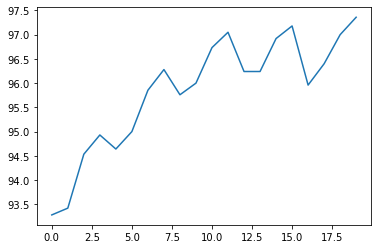

In [645]:
plt.plot(accuracy1, label='Accuracy')

## Pytorch's CNN Part

Since I have already downloaded the train and test data we don't need to do it again.

In [646]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [647]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

Because I am working with 2D images, the batch size will be greatly smaller

In [648]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Model Definition

#### First Convolutional Layer

1 input channel (One 2D image) --> 6 output channels (for feature extraction)

#### Second Convolutional Layer

6 input channel (One 2D image) --> 16 output channels (for feature extraction)

#### Three Linear Layers

* fc1 : 400 --> 120
* fc2 : 120 --> 84
* fc1 : 84 --> 10

In [649]:
class CNN(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, X):
        
        # From 28x28, due to the 3x3 kernel, it turns into 26x26
        X = F.relu(self.conv1(X))
        # From 26x26, due to max_pool, it turns into 13x13
        X = F.max_pool2d(X, 2, 2)
        
        # From 13x13, due to the 3x3 kernel, it turns into 11x11
        X = F.relu(self.conv2(X))
        # From 11x11, due to max_pool, it turns into 5x5
        X = F.max_pool2d(X, 2, 2)

        # 16 features X 5x5 images
        X = X.view(-1, 16*5*5)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [650]:
torch.manual_seed(42)
cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [651]:
accuracy2 = []

def experiment_cnn(cnn, epochs, lr):
    
    import time
    start_time = time.time()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0
    
        for b, (X_train, y_train) in enumerate(train_loader):
            b += 1
            
            y_pred = cnn(X_train)
            loss = criterion(y_pred, y_train)
            
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if b%1200 == 0:
                print(f'epoch: {i:2} | train_batch: {b:4} [{10*b:6}/60000] | train_loss: {loss.item():10.8f} | train_accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

        
        train_losses.append(loss)
        train_correct.append(trn_corr)
        
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):
                b += 1
                y_val = cnn(X_test)
                
                predicted = torch.max(y_val.data, 1)[1] 
                tst_corr += (predicted == y_test).sum()
                
                if b%200 == 0:
                    accuracy2.append(tst_corr.item()*100/(10*b))
                    print(f'epoch: {i:2} | test_batch: {b:4} [{10*b:6}/10000] | test_loss: {loss.item():10.8f} | test_accuracy: {accuracy2[-1]:7.3f}%')
            
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)
        
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')

In [652]:
torch.manual_seed(42)
cnn = CNN()
experiment_cnn(cnn, 5, 0.001)

epoch:  0 | train_batch: 1200 [ 12000/60000] | train_loss: 0.09464751 | train_accuracy:  85.333%
epoch:  0 | train_batch: 2400 [ 24000/60000] | train_loss: 0.06591819 | train_accuracy:  90.213%
epoch:  0 | train_batch: 3600 [ 36000/60000] | train_loss: 0.03400535 | train_accuracy:  92.317%
epoch:  0 | train_batch: 4800 [ 48000/60000] | train_loss: 0.00422920 | train_accuracy:  93.427%
epoch:  0 | train_batch: 6000 [ 60000/60000] | train_loss: 0.05711427 | train_accuracy:  94.240%
epoch:  0 | test_batch:  200 [  2000/10000] | test_loss: 0.05711427 | test_accuracy:  97.700%
epoch:  0 | test_batch:  400 [  4000/10000] | test_loss: 0.05711427 | test_accuracy:  97.600%
epoch:  0 | test_batch:  600 [  6000/10000] | test_loss: 0.05711427 | test_accuracy:  97.767%
epoch:  0 | test_batch:  800 [  8000/10000] | test_loss: 0.05711427 | test_accuracy:  97.938%
epoch:  0 | test_batch: 1000 [ 10000/10000] | test_loss: 0.05711427 | test_accuracy:  98.090%
epoch:  1 | train_batch: 1200 [ 12000/60000] 

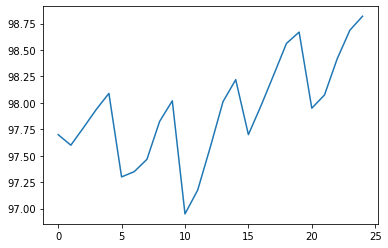

In [653]:
plt.plot(np.array(accuracy2), label='Accuracy')

## From Scratch Part
I won't be using the downloaded dataset, instead I will store them in a numpy array in accordance with the first assignment.

In [654]:
import os
import urllib

# Define where you want your files to be downloaded
path_to_store = "./MNIST/"
# Create a directory there
os.makedirs(path_to_store)

# Store the URLs of the 4 files from the MNIST website
urls = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

for url in urls:
    
    name_of_file = url.split('/')[-1]
    urllib.request.urlretrieve(url, path_to_store + name_of_file)

print(f"[\u2713] All files were downloaded!")

[✓] All files were downloaded!


In [655]:
import gzip
import shutil

files = os.listdir(path_to_store)

for file in files:
    if file.endswith('gz'):
        with gzip.open(path_to_store + file, 'rb')  as f_in:
            with open(path_to_store + file.split('.')[0], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

for file in files:
    os.remove(path_to_store + file)

In [656]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [657]:
import codecs
import numpy as np

files = os.listdir(path_to_store)

for file in files:
    if file.endswith('ubyte'):
        with open(path_to_store + file, 'rb') as f:
            data = f.read()
            magic_number = get_int(data[:4])
            length = get_int(data[4:8])
            if (magic_number == 2051):
                images = np.frombuffer(data, dtype= np.uint8, offset = 16).reshape(length, 784)
                if(length == 60000):
                    train_images = images/255 # normalization
                if(length == 10000):
                    test_images = images/255 # normalization
            elif (magic_number == 2049):
                labels = np.frombuffer(data, dtype= np.uint8, offset = 8).reshape(length)
                if(length == 60000):
                    train_labels = labels
                if(length == 10000):
                    test_labels = labels

In [658]:
train_images.shape, train_labels.shape

((60000, 784), (60000,))

In [659]:
onehot = np.zeros((60000,10))
for i in range(60000):
    onehot[i][train_labels[i]] = 1
train_labels = np.copy(onehot)
train_images.shape, train_labels.shape

((60000, 784), (60000, 10))

In [660]:
test_images.shape, test_labels.shape

((10000, 784), (10000,))

In [661]:
onehot = np.zeros((10000,10))
for i in range(10000):
    onehot[i][test_labels[i]] = 1
test_labels = np.copy(onehot)
test_images.shape, test_labels.shape

((10000, 784), (10000, 10))

In [662]:
train_data = list(zip(train_images, train_labels))
test_data = list(zip(test_images, test_labels))

### Network description:
#### biases
For every layer in the network there is an array of biases. Suppose the hidden layer has 3 --> 4 --> 5 neurons per layer. Then the matrix of biases, will have 3 columns. The first column will have 3 rows, the second 4 and the third will have 5. The input layer doesn't have biases.
#### weights
To understand how I store the weights you have to think the following. First, in which layer is the neuron in? Let's say it is the ith neuron of the 4th layer. Now, we are interested in which the weight connected this neuron and the jth neuron of the previous layer. This is the i,j entry in the matrix weights[3]

#### There are four main equations
* $\delta^L = \nabla_aC\odot\sigma'(z^L)$

which gives as the error of the last layer

* $\delta^l = ((w^{l+1})^T \delta^{l+1}) \odot \sigma'(z^l)$

the error of the left layer knowing the error of the right layer

* $\frac{\partial C}{\partial b^l_j} = \delta^l_j$

the rate of change of the cost function with respect to the jth bias of the l layer

* $\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j$

the rate of change of the cost function with respect to the weight connecting the jth neuron in the l layer with the kth neuron in the l-1 layer

where σ() denotes the sigmoid function and C is the quadratic cost.

We require those four equations because we are going to update the weights and biases using the following equations:

* $w^l \rightarrow w^l-\frac{\eta}{m} \sum_x \delta^{x,l} (a^{x,l-1})^T$


* $b^l \rightarrow b^l-\frac{\eta}{m}\sum_x \delta^{x,l}$

In [663]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [664]:
accuracy3 = []
wrong_guesses = []

class Network:
    
    def __init__(self, sizes):
        # Store the number of layers
        self.num_layers = len(sizes)
        # Store the neurons per layer array named "sizes"
        self.sizes = sizes
        # Each neuron in each layer has 1 bias except the neurons
        # in the input layer
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        # Each neuron in each layer has n weights where n is the
        # number of neurons in the previous layer
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
    
    def feed_input_forward(self, a):
        # Take input of 784x1 and by going through each layer,
        # find the 10x1 output
        # This simply computes a=s(z) where z = w.a + b
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def apply_stochastic_gradient_descent(self, epochs, mini_batch_size, lr):
        # For every epoch split the training data into minibatches
        for epoch in range(epochs):
            random.shuffle(train_data)
            mini_batches = [train_data[k:k+mini_batch_size] for k in range(0, len(train_data), mini_batch_size)]
            # For each mini batch take a step, a.k.a update weights and biases
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr)
            percentage = (self.evaluate(test_data)/(len(test_data))*100)
            accuracy3.append(percentage)
            print(f'Epoch {epoch}: | accuracy : {accuracy3[-1]}%')
            
    def update_mini_batch(self, mini_batch, lr):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x.reshape(784,1), y.reshape(10,1))
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(lr/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(lr/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
    """
    Returns the partial derivatives of the cost function with respect
    to the weights, and the biases OF A SINGLE TRAINING IMAGE
    """
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        # First, store the first activation, which is the input
        activations = [x]
        # The weighted input array is empty
        zs = []
        # Find the weighted input vector for every layer and add it
        # in the array
        # Then apply the sigmoid and add it to the activations
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # compute d^L which is the error for the LAST layer (EQ. 1)
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        # Compute rate of change of cost function with respect to the biases
        # of the neurons in the last layer using EQ. 3
        nabla_b[-1] = delta
        # Compute rate of change of cost function with respect to the weights
        # of the neurons in the last layer using EQ. 4
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            # Start from the second to last layer
            # compute the prime in the weighted input of the second to last
            # layer
            z = zs[-l]
            sp = sigmoid_prime(z)
            # delta --> the error of the previous layer
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
        
    def evaluate(self, test_data):
        count = 0
        index = 0
        for x, y in test_data:
            neuron_prediction = self.feed_input_forward(x.reshape(784,1))
            desired_output = y.reshape(10,1)
            if np.argmax(neuron_prediction) == np.argmax(desired_output):
                count += 1
            else:
                wrong_guesses.append(test_data[index][0])
            index += 1
        return count

    def cost_derivative(self, output_activations, y):
        return (output_activations.reshape(10,1)-y.reshape(10,1))

In [665]:
net = Network([784,30,10])
start = time.time()
net.apply_stochastic_gradient_descent(20, 100, 3.5)
end = time.time()

print(f'Time required : {(end-start)/60} minutes.')

Epoch 0: | accuracy : 78.48%
Epoch 1: | accuracy : 86.32%
Epoch 2: | accuracy : 88.32%
Epoch 3: | accuracy : 89.52%
Epoch 4: | accuracy : 90.14%
Epoch 5: | accuracy : 90.8%
Epoch 6: | accuracy : 91.33%
Epoch 7: | accuracy : 91.57%
Epoch 8: | accuracy : 91.81%
Epoch 9: | accuracy : 91.89%
Epoch 10: | accuracy : 92.12%
Epoch 11: | accuracy : 92.46%
Epoch 12: | accuracy : 92.33%
Epoch 13: | accuracy : 92.61%
Epoch 14: | accuracy : 92.58%
Epoch 15: | accuracy : 92.77%
Epoch 16: | accuracy : 92.84%
Epoch 17: | accuracy : 93.02%
Epoch 18: | accuracy : 93.12%
Epoch 19: | accuracy : 93.15%
Time required : 3.547578243414561 minutes.


Let's see which images the network got wrong!

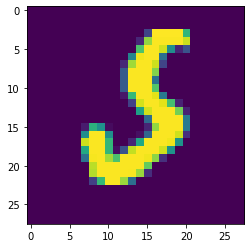

In [666]:
plt.imshow(wrong_guesses[-1].reshape(28,28))

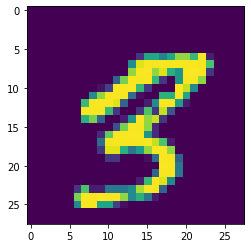

In [667]:
plt.imshow(wrong_guesses[-3].reshape(28,28))

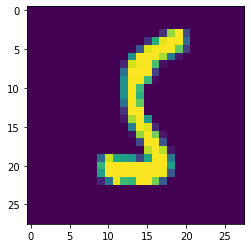

In [668]:
plt.imshow(wrong_guesses[-10].reshape(28,28))

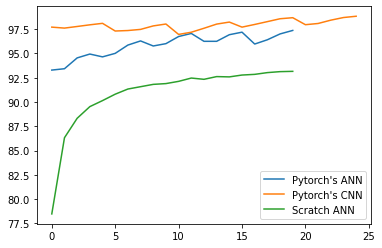

In [669]:
plt.plot(accuracy1, label="Pytorch's ANN")
plt.plot(accuracy2, label="Pytorch's CNN")
plt.plot(accuracy3, label="Scratch ANN")
plt.legend()